<a href="https://colab.research.google.com/github/Abhishek8901223/abhi/blob/main/Anomaly%20Detection%20in%20CloudMonitor%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive

In [23]:
drive.mount('/content/drive')

Mounted at /content/drive


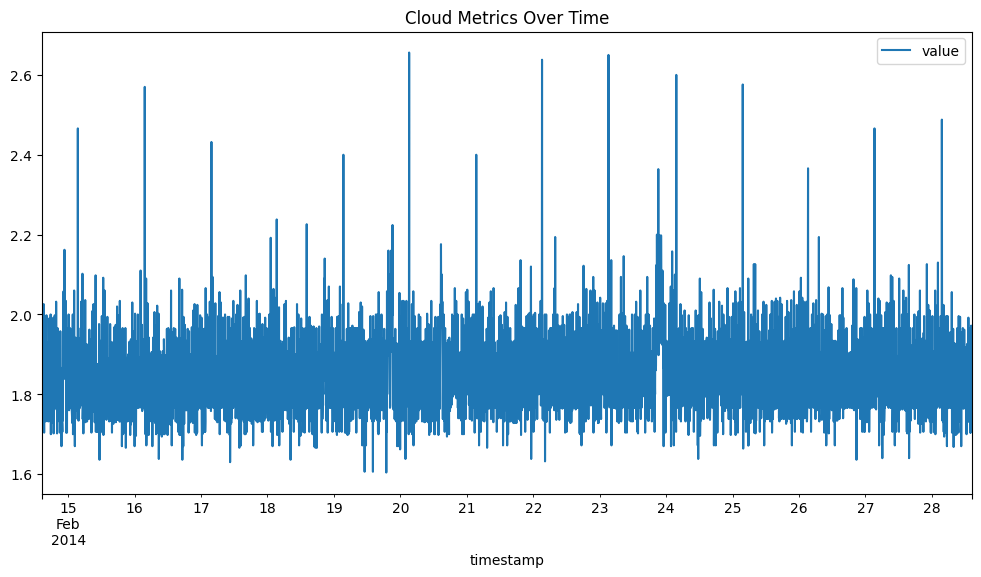

Number of anomalies detected: 191


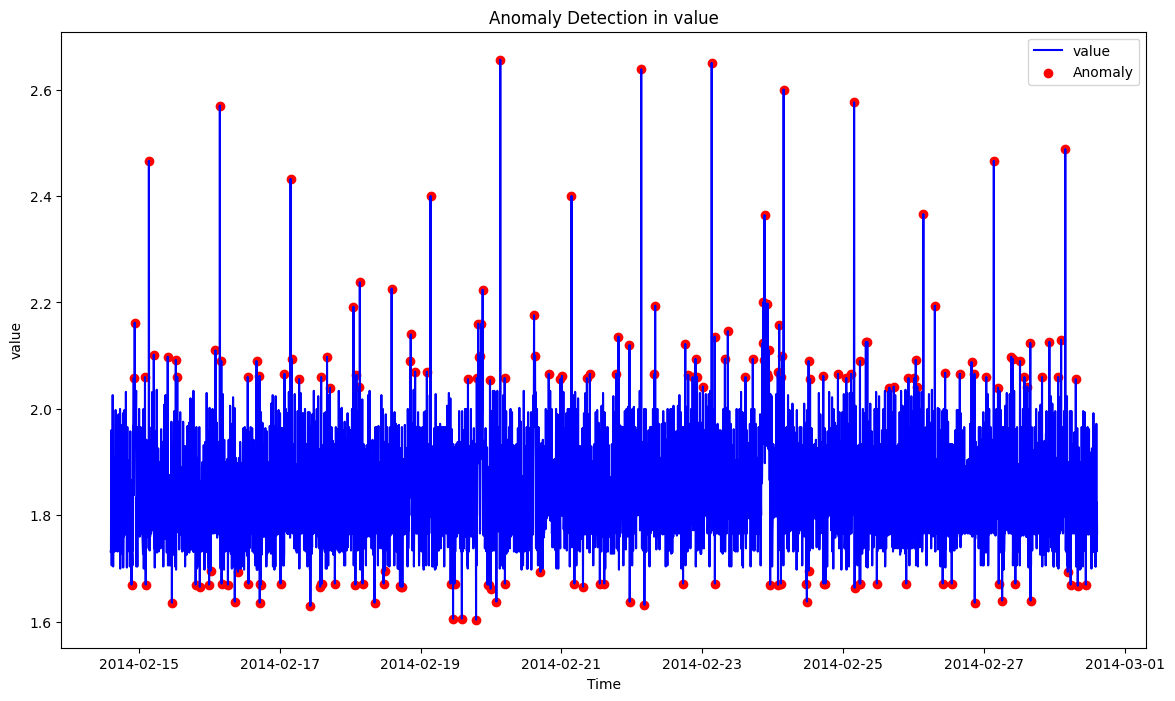

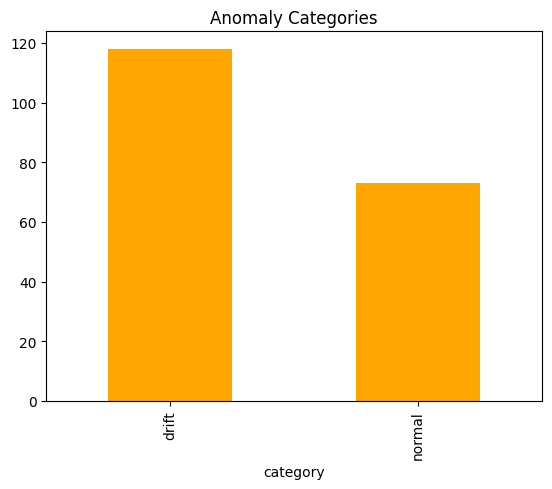

                     value category  severity_score
timestamp                                          
2014-02-20 03:10:00  2.656    drift        8.145690
2014-02-23 03:10:00  2.650    drift        8.086552
2014-02-22 03:10:00  2.638    drift        7.968277
2014-02-24 03:40:00  2.600    drift        7.593737
2014-02-25 03:40:00  2.576    drift        7.357186
...                    ...      ...             ...
2014-02-20 16:50:00  1.694   normal        1.336072
2014-02-28 04:25:00  1.694   normal        1.336072
2014-02-16 00:30:00  1.696   normal        1.316359
2014-02-24 12:15:00  1.696   normal        1.316359
2014-02-18 11:55:00  1.696   normal        1.316359

[191 rows x 3 columns]
Top 5 critical anomalies:
                     value category  severity_score
timestamp                                          
2014-02-20 03:10:00  2.656    drift        8.145690
2014-02-23 03:10:00  2.650    drift        8.086552
2014-02-22 03:10:00  2.638    drift        7.968277
2014-02-24 03:

In [51]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Step 1: Load Data
# Replace with your actual dataset path
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_cpu_utilization_5f5533.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_cpu_utilization_77c1ca.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_cpu_utilization_825cc2.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_cpu_utilization_ac20cd.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_cpu_utilization_c6585a.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_cpu_utilization_fe7f93.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_disk_write_bytes_1ef3de.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_disk_write_bytes_c0d644.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_network_in_257a54.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_network_in_5abac7.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/elb_request_count_8c0756.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/grok_asg_anomaly.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/iio_us-east-1_i-a2eb1cd9_NetworkIn.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/rds_cpu_utilization_cc0c53.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/rds_cpu_utilization_e47b3b.csv')
data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_cpu_utilization_24ae8d.csv')

data = pd.read_csv('/content/drive/MyDrive/computing-usage-dataset/computing-usage-dataset/ec2_cpu_utilization_53ea38.csv')
# Assuming the dataset has columns like ['timestamp', 'value', 'network_traffic', 'disk_io']
# Set the timestamp column as index
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Visualize initial data
data.plot(figsize=(12,6))
plt.title('Cloud Metrics Over Time')
plt.show()

# Step 2: Data Preprocessing
# Standardize the data
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# Step 3: Anomaly Detection using Isolation Forest
# Initialize Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)  # contamination is the proportion of anomalies
model.fit(data_scaled)

# Predict anomalies (-1 means anomaly, 1 means normal)
data['anomaly'] = model.predict(data_scaled)
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})  # Map 1 to normal and -1 to anomaly

# Display the number of anomalies
print(f"Number of anomalies detected: {data['anomaly'].sum()}")

# Step 4: Categorize the Detected Anomalies
def categorize_anomaly(row):
    if row['anomaly'] == 1:
        # Spike detection: if value suddenly increases
        if row['value'] > 1.5 * data['value'].mean():
            return 'spike'
        # Drift detection: if value increases gradually
        elif row['value'] > data['value'].mean() and row['value'] > data.loc[row.name - pd.Timedelta(minutes=5), 'value']:
            return 'drift'
        # Drop detection: if value drops suddenly
        elif row['value'] < 0.5 * data['value'].mean():
            return 'drop'
    return 'normal'

# Apply categorization
data['category'] = data.apply(categorize_anomaly, axis=1)

# Step 5: Visualization
# Plot data with anomalies highlighted
plt.figure(figsize=(14,8))
plt.plot(data.index, data['value'], label='value', color='blue')

# Plot anomalies
anomalies = data[data['anomaly'] == 1]
plt.scatter(anomalies.index, anomalies['value'], color='red', label='Anomaly')

plt.title('Anomaly Detection in value')
plt.xlabel('Time')
plt.ylabel('value')
plt.legend()
plt.show()

# Plot categorized anomalies
categories = data[data['anomaly'] == 1].groupby('category').size()
categories.plot(kind='bar', color='orange', title='Anomaly Categories')
plt.show()

# Step 6: Anomaly Scoring (Optional)
def anomaly_score(row):
    if row['anomaly'] == 1:
        return abs(row['value'] - data['value'].mean()) / data['value'].std()
    return 0

data['severity_score'] = data.apply(anomaly_score, axis=1)

# Display anomalies with severity score
print(data[data['anomaly'] == 1][['value', 'category', 'severity_score']].sort_values(by='severity_score', ascending=False))

# Step 7: Insights Summary
top_anomalies = data[data['anomaly'] == 1].nlargest(5, 'severity_score')
print("Top 5 critical anomalies:")
print(top_anomalies[['value', 'category', 'severity_score']])
